In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import (LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer, MultiLabelBinarizer)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_validate, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import TargetEncoder
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, r2_score

from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def caracteristiquesFichier(fichier):
    DataFrame = pd.read_csv(fichier,sep=',')
    DataFrame.describe()
    display(DataFrame)
    print(DataFrame.shape)
    print(DataFrame.dtypes)
    print(f'La moyenne de valeurs manquantes est de : {DataFrame.isna().mean()}')
    return DataFrame

def model_selection(X_train, y_train, X_test, y_test, estimator):
    """
    Test various estimators.
    """
    # Prétraitement des données
    preprocessor = make_column_transformer(
        (StandardScaler(), X_train.select_dtypes(include='number').columns.tolist()),
        (OneHotEncoder(sparse=False, handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist())
    )
    
    # Création du pipeline avec l'estimateur
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('estimator', estimator)
    ])

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions
    predicted = model.predict(X_test)

    # Calculer et retourner les scores
    training_score = model.score(X_train, y_train)
    r2 = r2_score(y_test, predicted)
    validation_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, predicted)

    return {
        "training_score": training_score,
        "r2_score": r2,
        "estimator": estimator,
        "validation_score": validation_score,
        "mse": mse
    }

# Fonction pour effectuer la validation croisée et collecter les résultats
def cross_val_results(models, X, y, cv=5):
    results = []
    for name, model in models:
        kfold = KFold(n_splits=cv, shuffle=True, random_state=1)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='r2')
        results.append((name, cv_results, model))
    return results

# Extraction des scores et noms des estimateurs pour les deux ensembles de résultats
def extract_scores(results):
    estimator_names = []
    training_scores = []
    r2_scores = []
    validation_scores = []
    
    for name, cv_results, model in results:
        estimator_names.append(name)
        training_scores.append(cv_results.mean())
        r2_scores.append(np.mean(cv_results))
        validation_scores.append(cv_results.mean())
    
    return estimator_names, training_scores, r2_scores, validation_scores


In [3]:
df = caracteristiquesFichier('df_final.csv')
df['ENERGYSTARScore'] = df['ENERGYSTARScore'].fillna(0)

,Latitude,Longitude,Agebuilding,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEUIWN(kBtu/sf),TotalGHGEmissions
0,47.61500,-122.33081,86,1.0,2,67224,0,67224,Commerce,NaN,19.500000,9.13
1,47.66410,-122.33118,110,1.0,3,87262,0,87262,Bureau,NaN,69.800003,157.77
2,47.66172,-122.29598,61,1.0,2,110356,0,110356,Industrie,NaN,12.400000,3.93
3,47.65671,-122.39047,26,1.0,2,54986,0,54986,Education,97.0,32.799999,31.47
4,47.66587,-122.38476,55,1.0,2,94900,0,94900,Bureau,57.0,68.900002,130.56
...,...,...,...,...,...,...,...,...,...,...,...,...
826,47.60775,-122.30225,22,1.0,1,20050,0,20050,Loisirs,NaN,99.400002,60.81
827,47.54067,-122.37441,34,1.0,1,18261,0,18261,Loisirs,NaN,56.200001,20.33
828,47.59625,-122.32283,12,1.0,1,16000,0,16000,Loisirs,NaN,65.900002,32.17
829,47.52832,-122.32431,27,1.0,1,14101,0,14101,Loisirs,NaN,55.500000,22.11


(831, 12)
Latitude                  float64
Longitude                 float64
Agebuilding                 int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFATotal            int64
PropertyGFAParking          int64
PropertyGFABuilding(s)      int64
LargestPropertyUseType     object
ENERGYSTARScore           float64
SiteEUIWN(kBtu/sf)        float64
TotalGHGEmissions         float64
dtype: object
La moyenne de valeurs manquantes est de : Latitude                  0.000000
Longitude                 0.000000
Agebuilding               0.000000
NumberofBuildings         0.000000
NumberofFloors            0.000000
PropertyGFATotal          0.000000
PropertyGFAParking        0.000000
PropertyGFABuilding(s)    0.000000
LargestPropertyUseType    0.000000
ENERGYSTARScore           0.368231
SiteEUIWN(kBtu/sf)        0.000000
TotalGHGEmissions         0.000000
dtype: float64


In [4]:
# #separation de la colonne ENERGYSTARScore
# energystarscore_df = df['ENERGYSTARScore']

In [5]:
# df.drop(['ENERGYSTARScore'], axis=1, inplace=True)

In [6]:
X = df[df.columns.drop(['TotalGHGEmissions'])]
y = df['TotalGHGEmissions']

In [7]:
df.columns

Index(['Latitude', 'Longitude', 'Agebuilding', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'ENERGYSTARScore',
       'SiteEUIWN(kBtu/sf)', 'TotalGHGEmissions'],
      dtype='object')

In [8]:
# Sélection des caractéristiques numériques
numerical_features = X.select_dtypes(include='number').columns.tolist()

# Sélection des caractéristiques catégorielles
categorical_features = X.select_dtypes(include='object').columns.tolist()


# # Pipeline pour les caractéristiques numériques
# numerical_pipeline = Pipeline([
#     ('scaler', StandardScaler())
# ])

# # Pipeline pour les caractéristiques catégorielles
# categorical_pipeline = Pipeline([
#     ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# # Préprocesseur combiné
# preprocessor = make_column_transformer(
#     (numerical_pipeline, numerical_features),
#     (categorical_pipeline, categorical_features)
# )


preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Liste des estimateurs à tester
estimators = [
    Ridge(),
    ElasticNet(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

In [11]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Collecter les résultats
results = []
for estimator in estimators:
    result = model_selection(X_train_df, y_train, X_test_df, y_test, estimator)
    results.append(result)

/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoder

In [12]:
# # Collecter les résultats
# results = []
# for estimator in estimators:
#     result = model_selection(X_train, y_train, X_test, y_test, estimator)
#     results.append(result)

In [13]:
for result in results:
    print("Estimateur:", result['estimator'].__class__.__name__)
    print("Score d'entraînement:", result['training_score'])
    print("Score de validation:", result['validation_score'])
    print("R2 score:", result['r2_score'])
    print("Erreur quadratique moyenne (MSE):", result['mse'])
    print("\n")

Estimateur: Ridge
Score d'entraînement: 0.5182703760101338
Score de validation: 0.48569456646032705
R2 score: 0.48569456646032705
Erreur quadratique moyenne (MSE): 573.672267592916


Estimateur: ElasticNet
Score d'entraînement: 0.4116516052459821
Score de validation: 0.4116101651753732
R2 score: 0.4116101651753732
Erreur quadratique moyenne (MSE): 656.3083116764842


Estimateur: RandomForestRegressor
Score d'entraînement: 0.9357245203479128
Score de validation: 0.5714391945875179
R2 score: 0.5714391945875179
Erreur quadratique moyenne (MSE): 478.03004403503


Estimateur: GradientBoostingRegressor
Score d'entraînement: 0.8478533745460929
Score de validation: 0.6043723776374883
R2 score: 0.6043723776374883
Erreur quadratique moyenne (MSE): 441.2953479434483




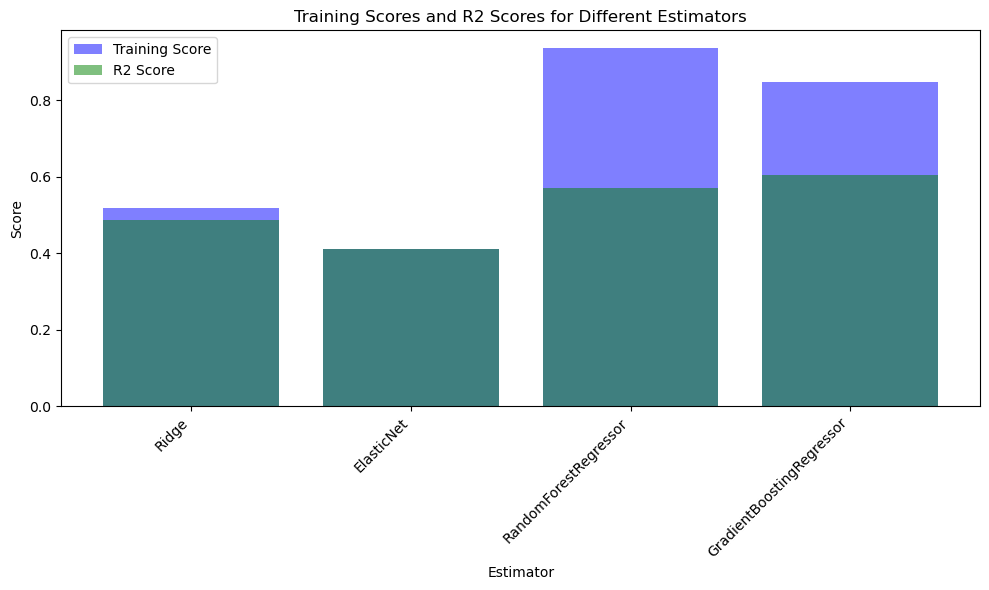

In [14]:
# Extraire les résultats
estimator_names = [result['estimator'].__class__.__name__ for result in results]
training_scores = [result['training_score'] for result in results]
r2_scores = [result['r2_score'] for result in results]

# Créer le barplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(estimator_names, training_scores, color='blue', alpha=0.5, label='Training Score')
ax.bar(estimator_names, r2_scores, color='green', alpha=0.5, label='R2 Score')
ax.set_xlabel('Estimator')
ax.set_ylabel('Score')
ax.set_title('Training Scores and R2 Scores for Different Estimators')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


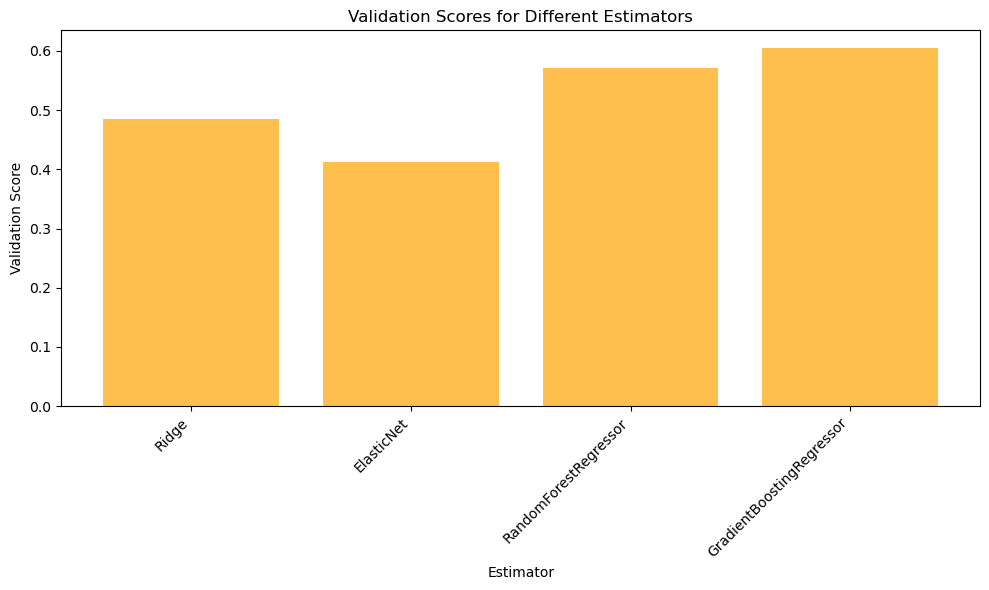

In [15]:
# Extraire les scores de validation
validation_scores = [result['validation_score'] for result in results]

# Créer le barplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(estimator_names, validation_scores, color='orange', alpha=0.7)
ax.set_xlabel('Estimator')
ax.set_ylabel('Validation Score')
ax.set_title('Validation Scores for Different Estimators')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Meilleure parametre pour les modéles

In [16]:
param_grids = [
    {
        'alpha': [0.1, 1.0, 10.0],  # Hyperparamètres pour la régression Ridge
    },
    {
        'alpha': [0.1, 1.0, 10.0],  # Hyperparamètres pour la régression ElasticNet
        'l1_ratio': [0.1, 0.5, 0.9],
    },
   {
        'n_estimators': [50, 100, 200],  # Hyperparamètres pour le modèle RandomForestRegressor
        'max_depth': [None, 10, 20],
    },
    {
        'n_estimators': [50, 100, 200],  # Hyperparamètres pour le modèle GradientBoostingRegressor
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
    }
]

# Prétraitement des données
X_train_processed = preprocessor.fit_transform(X_train_df)
X_test_processed = preprocessor.transform(X_test_df)

X_train_processed = pd.DataFrame(X_train_processed)
X_test_processed = pd.DataFrame(X_test_processed)


# Créer une liste de tuples (estimator, param_grid) pour chaque estimateur à tester
grid_search_estimators = [
    (estimator, param_grid) for estimator, param_grid in zip(estimators, param_grids)
]

# Collecter les meilleurs modèles
best_models = []

# Effectuer la recherche sur grille pour chaque estimateur
for estimator, param_grid in grid_search_estimators:
    # Créer une instance de GridSearchCV
    grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='r2')
    
    # Ajuster GridSearchCV sur les données d'entraînement prétraitées
    grid_search.fit(X_train_processed, y_train)
    
    # Ajouter le meilleur modèle à la liste des meilleurs modèles
    best_models.append(grid_search.best_estimator_)

# Afficher les meilleurs modèles et leurs paramètres
for model in best_models:
    print(model)

/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Ridge(alpha=10.0)
ElasticNet(alpha=0.1, l1_ratio=0.9)
RandomForestRegressor(max_depth=10, n_estimators=200)
GradientBoostingRegressor(learning_rate=0.2)


In [17]:
# Modèle Ridge avec les hyperparamètres spécifiés
ridge_model = Ridge()
ridge_model.fit(X_train_processed, y_train)
ridge_train_score = ridge_model.score(X_train_processed, y_train)
ridge_val_score = ridge_model.score(X_test_processed, y_test)
ridge_predictions = ridge_model.predict(X_test_processed)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

# Modèle ElasticNet avec les hyperparamètres spécifiés
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.9)
elasticnet_model.fit(X_train_processed, y_train)
elasticnet_train_score = elasticnet_model.score(X_train_processed, y_train)
elasticnet_val_score = elasticnet_model.score(X_test_processed, y_test)
elasticnet_predictions = elasticnet_model.predict(X_test_processed)
elasticnet_mse = mean_squared_error(y_test, elasticnet_predictions)
elasticnet_r2 = r2_score(y_test, elasticnet_predictions)

# Modèle RandomForestRegressor avec les hyperparamètres spécifiés
rf_model = RandomForestRegressor(max_depth=10, n_estimators=200)
rf_model.fit(X_train_processed, y_train)
rf_train_score = rf_model.score(X_train_processed, y_train)
rf_val_score = rf_model.score(X_test_processed, y_test)
rf_predictions = rf_model.predict(X_test_processed)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Modèle GradientBoostingRegressor avec les hyperparamètres spécifiés
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_processed, y_train)
gbr_train_score = gbr_model.score(X_train_processed, y_train)
gbr_val_score = gbr_model.score(X_test_processed, y_test)
gbr_predictions = gbr_model.predict(X_test_processed)
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

# Résultats des modèles
model_results = [
    {
        'estimator': ridge_model,
        'training_score': ridge_train_score,
        'validation_score': ridge_val_score,
        'r2_score': ridge_r2,
        'mse': ridge_mse
    },
    {
        'estimator': elasticnet_model,
        'training_score': elasticnet_train_score,
        'validation_score': elasticnet_val_score,
        'r2_score': elasticnet_r2,
        'mse': elasticnet_mse
    },
    {
        'estimator': rf_model,
        'training_score': rf_train_score,
        'validation_score': rf_val_score,
        'r2_score': rf_r2,
        'mse': rf_mse
    },
    {
        'estimator': gbr_model,
        'training_score': gbr_train_score,
        'validation_score': gbr_val_score,
        'r2_score': gbr_r2,
        'mse': gbr_mse
    }
]


In [18]:
for model_result in model_results:
    print("Estimateur:", model_result['estimator'].__class__.__name__)
    print("Score d'entraînement:", model_result['training_score'])
    print("Score de validation:", model_result['validation_score'])
    print("R2 score:", model_result['r2_score'])
    print("Erreur quadratique moyenne (MSE):", model_result['mse'])
    print("\n")

Estimateur: Ridge
Score d'entraînement: 0.5182703760101338
Score de validation: 0.48569456646032705
R2 score: 0.48569456646032705
Erreur quadratique moyenne (MSE): 573.672267592916


Estimateur: ElasticNet
Score d'entraînement: 0.5151183303941367
Score de validation: 0.4845446052021338
R2 score: 0.4845446052021338
Erreur quadratique moyenne (MSE): 574.954970126489


Estimateur: RandomForestRegressor
Score d'entraînement: 0.9233919875284794
Score de validation: 0.5531012743395842
R2 score: 0.5531012743395842
Erreur quadratique moyenne (MSE): 498.48473030806286


Estimateur: GradientBoostingRegressor
Score d'entraînement: 0.8478533745460929
Score de validation: 0.6047753322850833
R2 score: 0.6047753322850833
Erreur quadratique moyenne (MSE): 440.84587980380223




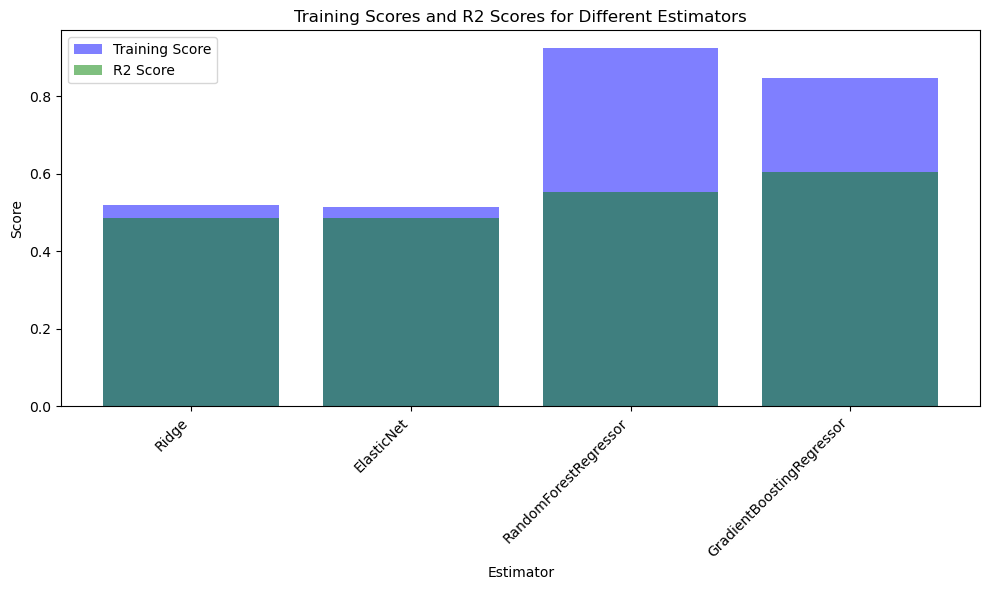

In [19]:
# Extraire les résultats
estimator_names = [model_result['estimator'].__class__.__name__ for model_result in model_results]
training_scores = [model_result['training_score'] for model_result in model_results]
r2_scores = [model_result['r2_score'] for model_result in model_results]

# Créer le barplot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(estimator_names, training_scores, color='blue', alpha=0.5, label='Training Score')
ax.bar(estimator_names, r2_scores, color='green', alpha=0.5, label='R2 Score')
ax.set_xlabel('Estimator')
ax.set_ylabel('Score')
ax.set_title('Training Scores and R2 Scores for Different Estimators')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

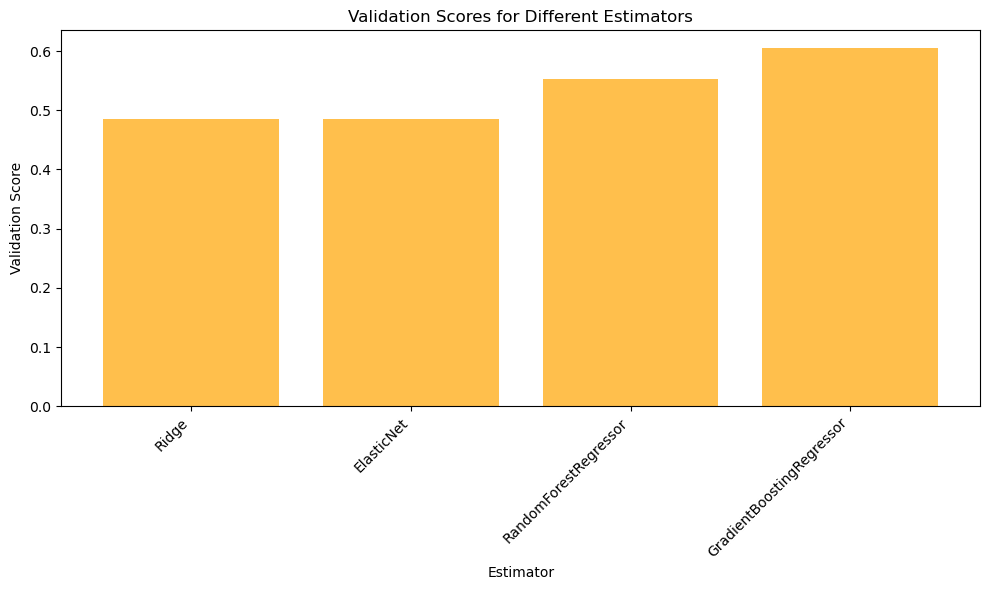

In [20]:
# Extraire les scores de validation
validation_scores = [model_result['validation_score'] for model_result in model_results]

# Créer le barplot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(estimator_names, validation_scores, color='orange', alpha=0.7)
ax.set_xlabel('Estimator')
ax.set_ylabel('Validation Score')
ax.set_title('Validation Scores for Different Estimators')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Validation croisée

In [21]:
model = LinearRegression()

# Utiliser le préprocesseur avec les DataFrames
X_train_validation = preprocessor.fit_transform(X_train_df)
X_test_validation = preprocessor.transform(X_train_df)

# Définir le nombre de plis pour la validation croisée
k = 5
# Initialisez la validation croisée avec KFold
kf = KFold(n_splits=k)

# Effectuer la validation croisée
scores = cross_val_score(model, X_train_validation, y_train, cv=kf, scoring='r2')  # 'r2' pour le coefficient de détermination

# Afficher les scores de validation croisée
print("Scores de validation croisée:", scores)
print("Moyenne des scores de validation croisée:", np.mean(scores))

Scores de validation croisée: [0.56082638 0.36126886 0.47302729 0.52665047 0.42986336]
Moyenne des scores de validation croisée: 0.4703272733845614


/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Feature importance

In [22]:
# Entraînement du modèle Random Forest
model = RandomForestRegressor()
model.fit(X_train_validation, y_train)

# Obtention de l'importance des caractéristiques
feature_importance = model.feature_importances_

# Affichage de l'importance des caractéristiques
for i, importance in enumerate(feature_importance):
    print(f"Feature {i}: {importance}")


Feature 0: 0.05130133971757153
Feature 1: 0.057238763613981156
Feature 2: 0.06948910978149701
Feature 3: 0.0
Feature 4: 0.04304238274091983
Feature 5: 0.07755840958880922
Feature 6: 0.027971357500271656
Feature 7: 0.16631946255202595
Feature 8: 0.03950227151223522
Feature 9: 0.4096388705044771
Feature 10: 0.005483881689333111
Feature 11: 0.02618311581235775
Feature 12: 0.007178011463231373
Feature 13: 0.0036115046997511283
Feature 14: 0.006076250678856842
Feature 15: 0.0034938602919875185
Feature 16: 0.000758957828318097
Feature 17: 0.0002545038726413001
Feature 18: 0.0048979461517342235


In [23]:
# Entraînement du modèle Random Forest
model = RandomForestRegressor()
model.fit(X_train_validation, y_train)

# Obtention de l'importance des caractéristiques
feature_importance = model.feature_importances_

# Affichage de l'importance des caractéristiques
for i, importance in enumerate(feature_importance):
    print(f"Feature {i}: {importance}")


Feature 0: 0.059528268588648466
Feature 1: 0.05909005916707546
Feature 2: 0.0726236190520269
Feature 3: 0.0
Feature 4: 0.03895368678610496
Feature 5: 0.07991555143647074
Feature 6: 0.0255030881738814
Feature 7: 0.16719181791863344
Feature 8: 0.039788919309455544
Feature 9: 0.40038891019777356
Feature 10: 0.004665534278542714
Feature 11: 0.022548371082597284
Feature 12: 0.007878064628838026
Feature 13: 0.004196001026792773
Feature 14: 0.007446071075626948
Feature 15: 0.004341801810207018
Feature 16: 0.0009593045481515944
Feature 17: 0.00023224782194325186
Feature 18: 0.004748683097230114


Energy star score

In [24]:
# Préparer les variables X et y
X_with_var = df.drop(columns=['TotalGHGEmissions'])  # Exclure la colonne cible des caractéristiques
y = df['TotalGHGEmissions']

non_numeric_columns = X_with_var.select_dtypes(include=['object']).columns

# Encoder les colonnes non numériques
encoder = OneHotEncoder(sparse=False, drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(X_with_var[non_numeric_columns]), index=X_with_var.index)
X_encoded.columns = encoder.get_feature_names_out(non_numeric_columns)

# Remplacer les colonnes non numériques par leurs versions encodées
X_with_var = X_with_var.drop(columns=non_numeric_columns).join(X_encoded)
X_without_var = X_with_var.drop(columns='ENERGYSTARScore')

# Modèle avec toutes les caractéristiques
model_all_features = LinearRegression()
model_all_features.fit(X_with_var, y)
y_pred_all_features = model_all_features.predict(X_with_var)
r2_all_features = r2_score(y, y_pred_all_features)
print("R2 avec ENERGYSTARScore :", r2_all_features)

# Modèle sans la caractéristique ENERGYSTARScore
model_reduced_features = LinearRegression()
model_reduced_features.fit(X_without_var, y)
y_pred_reduced_features = model_reduced_features.predict(X_without_var)
r2_reduced_features = r2_score(y, y_pred_reduced_features)
print("R2 sans ENERGYSTARScore :", r2_reduced_features)


R2 avec ENERGYSTARScore : 0.514672013848152
R2 sans ENERGYSTARScore : 0.5135281089907375


/Users/chloeroudaut/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


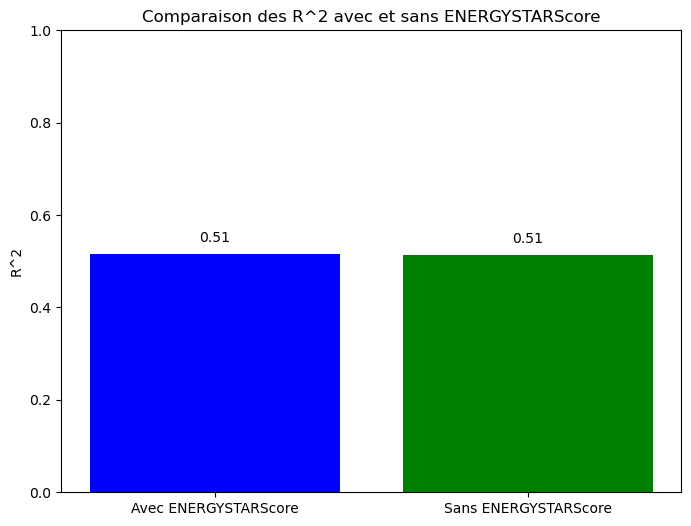

In [25]:
# Plot des résultats
labels = ['Avec ENERGYSTARScore', 'Sans ENERGYSTARScore']
r2_values = [r2_all_features, r2_reduced_features]

plt.figure(figsize=(8, 6))
plt.bar(labels, r2_values, color=['blue', 'green'])
plt.ylabel('R^2')
plt.title('Comparaison des R^2 avec et sans ENERGYSTARScore')
plt.ylim(0, 1)  # Assuming R^2 values are between 0 and 1
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.show()